In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table, join, unique, vstack

Found 3813 unique bricks
Found 3468 unique bricks with ELG targets


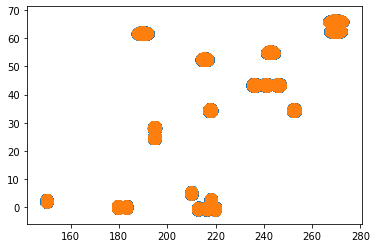

In [3]:
dirname = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS'
targets = Table.read(os.path.join(dirname,'dark_targets.fits'))
print('Found {:d} unique bricks'.format(np.unique(targets['BRICKNAME']).size))
targets_ELG = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/2/ELG_HIP_full.dat.fits')
print('Found {:d} unique bricks with ELG targets'.format(np.unique(targets_ELG['BRICKNAME']).size))
plt.scatter(targets['RA'],targets['DEC'],marker='.')
mask = targets_ELG['PHOTSYS'] == targets_ELG['PHOTSYS']
plt.scatter(targets_ELG['RA'][mask],targets_ELG['DEC'][mask],marker='.')

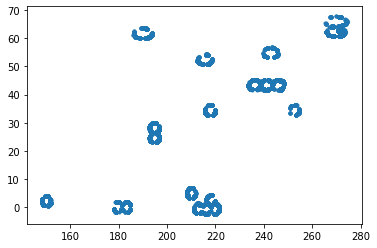

In [4]:
mask = ~np.isin(targets['BRICKNAME'],targets_ELG['BRICKNAME'])
plt.scatter(targets['RA'][mask],targets['DEC'][mask],marker='.')

In [5]:
print(np.unique(targets_ELG['PHOTSYS']))

PHOTSYS
-------
      N
      S


In [6]:
index,counts = np.unique(targets_ELG['BRICKNAME'],return_counts=True)
print('{} targets per brick'.format(np.median(counts)))

113.0 targets per brick


In [7]:
for region in ['N','S']:
    filename = 'bricklist_{}.txt'.format('north' if region == 'N' else 'south')
    mask = targets['PHOTSYS'] == region
    with open(filename,'w') as file:
        for brickname in np.unique(targets['BRICKNAME'][mask]):
            file.write('{}\n'.format(brickname))

In [8]:
from photometry import utils
brickdepth = {}
bands = 'GRZ'
for b in bands:
    brickdepth[b] = utils.digitized_statistics(targets['BRICKNAME'],values=targets['GALDEPTH_{}'.format(b)],statistic='median')

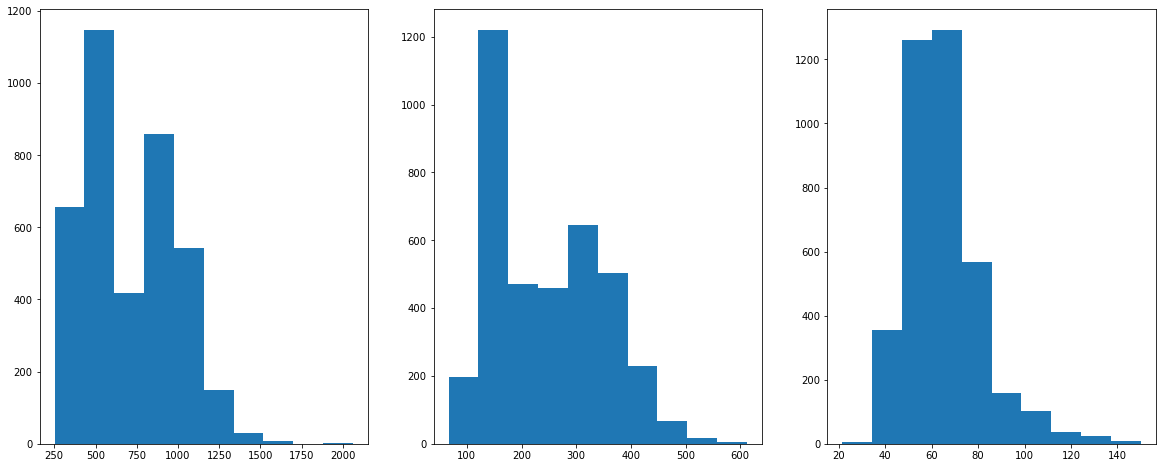

In [9]:
fig,lax = plt.subplots(ncols=len(bands),nrows=1,sharex=False,sharey=False,figsize=(20,8))
lax = lax.flatten()
indices = np.unique(targets['BRICKNAME'],return_index=True)[1]

for ax, b in zip(lax, bands):
    ax.hist(brickdepth[b][indices])

In [10]:
fn = os.path.join(os.getenv('HOME'),'photometry','truth_cosmos_deep.fits')
truth = Table.read(fn)
snr = {b: truth['flux_%s' % b] * np.sqrt(truth['flux_ivar_%s' % b]) for b in ['g','r','z']}
mask = truth['hsc_object_id'] >= 0

def get_imaging_maskbits(bitnamelist=None):
    """Return MASKBITS names and bits from the Legacy Surveys.
    Parameters
    ----------
    bitnamelist : :class:`list`, optional, defaults to ``None``
        If not ``None``, return the bit values corresponding to the
        passed names. Otherwise, return the full MASKBITS dictionary.
    Returns
    -------
    :class:`list` or `dict`
        A list of the MASKBITS values if `bitnamelist` is passed,
        otherwise the full MASKBITS dictionary of names-to-values.
    Notes
    -----
    - For the definitions of the mask bits, see, e.g.,
      https://www.legacysurvey.org/dr8/bitmasks/#maskbits
    """
    bitdict = {"BRIGHT": 1, "ALLMASK_G": 5, "ALLMASK_R": 6, "ALLMASK_Z": 7,
               "BAILOUT": 10, "MEDIUM": 11, "GALAXY": 12, "CLUSTER": 13}

    # ADM look up the bit value for each passed bit name.
    if bitnamelist is not None:
        return [bitdict[bitname] for bitname in bitnamelist]

    return bitdict


def get_default_maskbits(bgs=False, mws=False):
    """Return the names of the default MASKBITS for targets.
    Parameters
    ----------
    bgs : :class:`bool`, defaults to ``False``.
        If ``True`` load the "default" scheme for Bright Galaxy Survey
        targets. Otherwise, load the default for other target classes.
    mws : :class:`bool`, defaults to ``False``.
        If ``True`` load the "default" scheme for Milky Way Survey
        targets. Otherwise, load the default for other target classes.
    Returns
    -------
    :class:`list`
        A list of the default MASKBITS names for targets.
    Notes
    -----
    - Only one of `bgs` or `mws` can be ``True``.
    """
    if bgs and mws:
        msg = "Only one of bgs or mws can be passed as True"
        log.critical(msg)
        raise ValueError(msg)
    if bgs:
        return ["BRIGHT", "CLUSTER"]
    if mws:
        return ["BRIGHT", "GALAXY"]

    return ["BRIGHT", "GALAXY", "CLUSTER"]


def imaging_mask(maskbits, bitnamelist=get_default_maskbits(),
                 bgsmask=False, mwsmask=False):
    """Apply the 'geometric' masks from the Legacy Surveys imaging.
    Parameters
    ----------
    maskbits : :class:`~numpy.ndarray` or ``None``
        General array of `Legacy Surveys mask`_ bits.
    bitnamelist : :class:`list`, defaults to func:`get_default_maskbits()`
        List of Legacy Surveys mask bits to set to ``False``.
    bgsmask : :class:`bool`, defaults to ``False``.
        Load the "default" scheme for Bright Galaxy Survey targets.
        Overrides `bitnamelist`.
    bgsmask : :class:`bool`, defaults to ``False``.
        Load the "default" scheme for Milky Way Survey targets.
        Overrides `bitnamelist`.
    Returns
    -------
    :class:`~numpy.ndarray`
        A boolean array that is the same length as `maskbits` that
        contains ``False`` where any bits in `bitnamelist` are set.
    Notes
    -----
    - Only one of `bgsmask` or `mwsmask` can be ``True``.
    """
    # ADM default for the BGS or MWS..
    if bgsmask or mwsmask:
        bitnamelist = get_default_maskbits(bgs=bgsmask, mws=mwsmask)

    # ADM get the bit values for the passed (or default) bit names.
    bits = get_imaging_maskbits(bitnamelist)

    # ADM Create array of True and set to False where a mask bit is set.
    mb = np.ones_like(maskbits, dtype='?')
    for bit in bits:
        mb &= ((maskbits & 2**bit) == 0)

    return mb


def custom_imaging_mask(maskbits, bits=[1, 5, 6, 7, 11, 12, 13]):
    # BRIGHT, ALLMASK_G,R,Z, MEDIUM, GALAXY, CLUSTER
    mb = np.ones_like(maskbits, dtype='?')
    for bit in bits:
        mb &= ((maskbits & 2**bit) == 0)

    return mb


def notinELG_mask(maskbits=None, gsnr=None, rsnr=None, zsnr=None,
                  gnobs=None, rnobs=None, znobs=None, primary=None):
    """Standard set of masking cuts used by all ELG target selection classes.
    (see :func:`~desitarget.cuts.set_target_bits` for parameters).
    """
    if primary is None:
        primary = np.ones_like(maskbits, dtype='?')
    elg = primary.copy()

    # ADM good signal-to-noise in all bands.
    elg &= (gsnr > 0) & (rsnr > 0) & (zsnr > 0)

    # ADM observed in every band.
    elg &= (gnobs > 0) & (rnobs > 0) & (znobs > 0)

    # ADM default mask bits from the Legacy Surveys not set.
    #elg &= imaging_mask(maskbits)
    elg &= custom_imaging_mask(maskbits)

    return elg


def get_mask_depth(catalog, gth=4000., rth=2000., zth=500.):
    # Anand's cuts
    #mask = (catalog.get('brick_galdepth_g') > gth)
    #mask &= (catalog.get('brick_galdepth_r') > rth)
    #mask &= (catalog.get('brick_galdepth_z') > zth)
    mask = (catalog['galdepth_g'] > gth)
    mask &= (catalog['galdepth_r'] > rth)
    mask &= (catalog['galdepth_z'] > zth)
    return mask


def isELG_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 w2flux=None, gfiberflux=None, south=True, primary=None,
                 gmarg=0., grmarg=0., rzmarg=0.):
    """
    Apply ELG selection with box enlarged by ``gmarg``, ``grmarg``, ``rzmarg``.

    SV3 selection from https://github.com/desihub/desitarget/blob/7786db0931d23ed20de7ef37a6f07a52072e11ab/py/desitarget/sv3/sv3_cuts.py#L526
    """
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()

    # ADM work in magnitudes instead of fluxes. NOTE THIS IS ONLY OK AS
    # ADM the snr masking in ALL OF g, r AND z ENSURES positive fluxes.
    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))
    gfib = 22.5 - 2.5*np.log10(gfiberflux.clip(1e-16))

    # ADM cuts shared by the northern and southern selections.
    elg &= g > 20 - gmarg                # bright cut.
    elg &= r - z > 0.15 - rzmarg         # blue cut.
#    elg &= r - z < 1.6 + rzmarg         # red cut.

    # ADM cuts that are unique to the north or south. Identical for sv3
    # ADM but keep the north/south formalism in case we use it later.
    if south:
        elg &= gfib < 24.1 + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.
    else:
        elg &= gfib < 24. + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.

    # ADM separate a low-priority and a regular sample.
    elgvlo = elg.copy()

    # ADM low-priority OII flux cut.
    elgvlo &= g - r < -1.2*(r - z) + 1.6 + grmarg
    elgvlo &= g - r >= -1.2*(r - z) + 1.3 - grmarg

    # ADM high-priority OII flux cut.
    elg &= g - r < -1.2*(r - z) + 1.3 + grmarg

    return elgvlo, elg


def get_mask_ts(catalog, priority='all', **kwargs):
    mask_low, mask_high = isELG_colors(**{'%sflux' % b:utils.mag_to_flux(catalog[b]) for b in ['g','r','z','gfiber']},**kwargs)
    if priority == 'low': return mask_low
    if priority == 'high': return mask_high
    return (mask_low | mask_high)

marg = 1.0
mask &= notinELG_mask(maskbits=truth['maskbits'],gsnr=snr['g'],rsnr=snr['r'],zsnr=snr['z'],gnobs=truth['nobs_g'],rnobs=truth['nobs_r'],znobs=truth['nobs_z'])
mask &= get_mask_depth(truth)
mask_ts = mask & get_mask_ts(truth,south=True,gmarg=marg,grmarg=marg,rzmarg=marg)
print(mask_ts.sum()*1./mask.size)

0.031012716878542446


In [11]:
fn = '/global/cscratch1/sd/adematti/legacysim/dr9/SV3/north/file0_rs0_skip0/injected.fits'
#fn = '/global/cscratch1/sd/adematti/legacysim/dr9/SV3/north/file0_rs0_skip0/injected_randoms.fits'
injected = Table.read(fn)
print(len(injected)*1./np.unique(injected['brickname']).size)

540.5002602811036


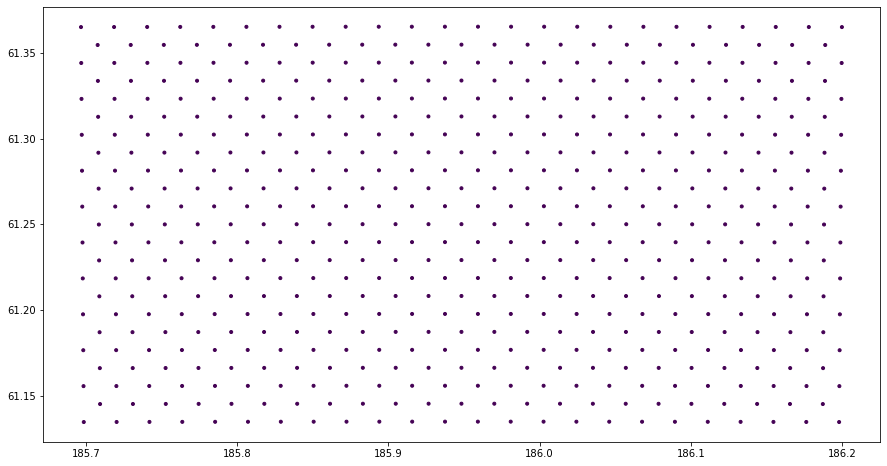

In [12]:
plt.figure(figsize=(15,8))
mask = injected['brickname'] == injected['brickname'][0]
unique,index,inverse = np.unique(injected['brickname'],return_index=True,return_inverse=True)
brickid = index[inverse]
#mask[:] = True
plt.scatter(injected['ra'][mask],injected['dec'][mask],marker='.',c=brickid[mask])

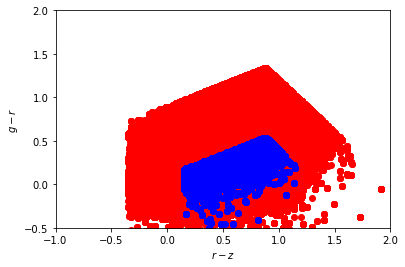

In [16]:
injected = Table.read(fn)
ax = plt.gca()
ax.scatter(injected['r'] - injected['z'], injected['g'] - injected['r'], color='r')
#mask = get_mask_ts(injected, priority='all', gmarg=0.5, grmarg=0.5, rzmarg=0.5)
mask = get_mask_ts(injected, priority='all', gmarg=0., grmarg=0., rzmarg=0.)
ax.scatter(injected['r'][mask] - injected['z'][mask], injected['g'][mask] - injected['r'][mask], color='b')
ax.set_xlim(-1.,2.)
ax.set_ylim(-0.5,2.)
ax.set_xlabel('$r-z$')
ax.set_ylabel('$g-r$')
plt.show()